### Diving deeper into the BBC News archive

In [1]:
import io
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
filename = "/Users/niloufar/Desktop/DeepLearning/tf_specialization/dataset/BBC News Train.csv"
with open(filename, 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

Each data point looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002.

In [3]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = '<OOV>'
TRAINING_SPLIT = .8

### Loading and pre-processing the data

In [4]:
def remove_stopwords(sentence):
    
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)
    return sentence

In [5]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[2])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)
            
    return sentences, labels

In [6]:
sentences, labels = parse_data_from_file(filename)
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 1490 sentences in the dataset.

First sentence has 203 words (after removing stopwords).

There are 1490 labels in the dataset.

The first 5 labels are ['business', 'business', 'business', 'tech', 'business']


### Training - Validation Split

In [7]:
def train_val_split(sentences, labels, training_split):
    train_size = int(len(sentences)*training_split)
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]
    
    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")


There are 1192 sentences for training.

There are 1192 labels for training.

There are 298 sentences for validation.

There are 298 labels for validation.


### Tokenization - Sequences and padding

In [9]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [10]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 22647 words

<OOV> token included in vocabulary


In [11]:
def seq_and_pad(sentences, toknizer, padding, maxlen):
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    return padded_sequences

In [12]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1192, 120)

Padded validation sequences have shape: (298, 120)


In [13]:
def tokenize_labels(all_labels, split_labels):
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(all_labels)
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [14]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [4]
 [1]]

First 5 labels of the validation set should look like this:
[[3]
 [3]
 [2]
 [1]
 [4]]

Tokenized labels of the training set have shape: (1192, 1)

Tokenized labels of the validation set have shape: (298, 1)



### Selecting the model for text classification

In [15]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [16]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))


Metal device set to: Apple M1
Epoch 1/30


2023-05-01 08:56:34.185584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 08:56:34.186188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-01 08:56:34.311151: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 6/38 [===>..........................] - ETA: 0s - loss: 1.6081 - accuracy: 0.2396 

2023-05-01 08:56:34.561205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 1s 15ms/step - loss: 1.6019 - accuracy: 0.3305 - val_loss: 1.5932 - val_accuracy: 0.3624
Epoch 2/30
12/38 [========>.....................] - ETA: 0s - loss: 1.5857 - accuracy: 0.4115

2023-05-01 08:56:35.183367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 0s 11ms/step - loss: 1.5778 - accuracy: 0.4211 - val_loss: 1.5625 - val_accuracy: 0.4228
Epoch 3/30
38/38 [==============================] - 0s 10ms/step - loss: 1.5316 - accuracy: 0.4614 - val_loss: 1.5052 - val_accuracy: 0.4396
Epoch 4/30
38/38 [==============================] - 0s 10ms/step - loss: 1.4490 - accuracy: 0.4698 - val_loss: 1.4115 - val_accuracy: 0.4329
Epoch 5/30
38/38 [==============================] - 0s 10ms/step - loss: 1.3266 - accuracy: 0.4648 - val_loss: 1.2895 - val_accuracy: 0.4262
Epoch 6/30
38/38 [==============================] - 0s 10ms/step - loss: 1.1897 - accuracy: 0.4740 - val_loss: 1.1640 - val_accuracy: 0.4530
Epoch 7/30
38/38 [==============================] - 0s 10ms/step - loss: 1.0588 - accuracy: 0.5218 - val_loss: 1.0472 - val_accuracy: 0.5570
Epoch 8/30
38/38 [==============================] - 0s 10ms/step - loss: 0.9431 - accuracy: 0.6518 - val_loss: 0.9401 - val_accuracy: 0.6913
Epoch 9/30
38/38 [======

In [ ]:
# !pip install tensorflow-metal==0.5.0

In [ ]:
# !pip install tensorflow-macos==2.9.0

In [17]:
model.predict(val_padded_seq[1:6])

1/1 [==============================] - 0s 136ms/step


2023-04-30 10:36:03.784325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[3.13511759e-04, 6.76924596e-04, 1.60779723e-06, 9.99003589e-01,
        4.41524207e-06],
       [1.23541523e-02, 3.55417840e-04, 9.82062638e-01, 1.75829846e-04,
        5.05200122e-03],
       [1.36048545e-03, 7.24976420e-01, 5.58408201e-02, 1.93581656e-01,
        2.42406633e-02],
       [2.51982798e-04, 2.02775840e-02, 1.12101017e-02, 9.42282146e-04,
        9.67318118e-01],
       [1.05731154e-03, 7.42552638e-01, 6.10369779e-02, 9.45767909e-02,
        1.00776315e-01]], dtype=float32)

In [17]:
val_label_seq[1:6]

array([[3],
       [2],
       [1],
       [4],
       [1]])

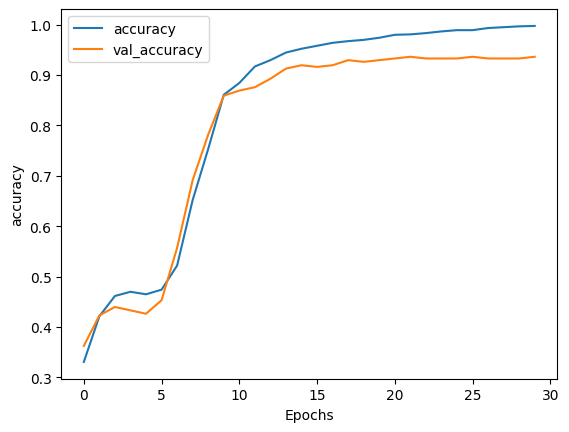

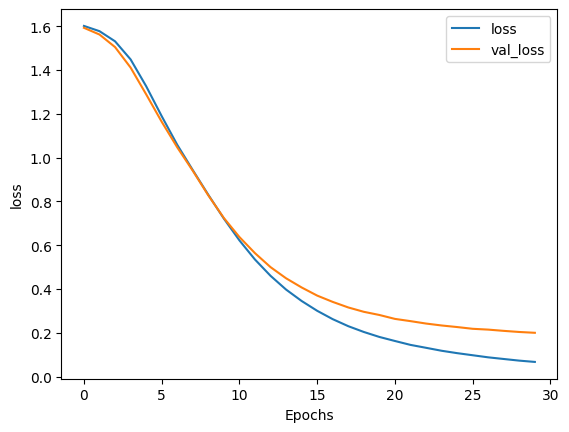

In [18]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")    

### Optional Exercise - Visualizing 3D Vectors

In [26]:
reverse_word_index = tokenizer.index_word

e = model.layers[0]
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [28]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
    
out_v.close()
out_m.close()